In [1]:
!pip3 install numpy tifffile psycopg2 --user

  Using cached https://files.pythonhosted.org/packages/87/2d/e4656149cbadd3a8a0369fcd1a9c7d61cc7b87b3903b85389c70c989a696/numpy-1.16.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/76/bc/80a4e8dad3f74c3b63aa652dbd2e753b3b110a51d74482d1b245870894eb/tifffile-2019.6.18-py2.py3-none-any.whl


In [2]:
import requests
import json
import numpy as np
import tifffile as tiff
import math
import tempfile
import os
import tiledb
import uuid

from datetime import datetime, timedelta

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
# tdmq constants
TDMQ_BASE_URL = 'http://web:8000/api/v0.0'
TILEDB_HDFS_ROOT = 'hdfs://hdfs:9000/arrays'
TDMQ_NAMESPACE_UUID = uuid.UUID('367b5aee-8609-3c20-b130-4eb927a2d62b')
TILEDB_CTX = tiledb.Ctx({'vfs.hdfs.username': 'root'})

In [5]:
dpc_meteoradar_mosaic_type = {
    "code": "0fd67c67-c9be-45c6-9719-4c4eada4ffff",
    "type": "meteoRadar",
    "name": "Mosaic of dpc meteo radars",
    "brandName": "DPC",
    "modelName": "dpc-radar-mosaic",
    "manufacturerName": "Dipartimento Protezione Civile",
    "category": ["sensor"],
    "function": ["sensing"],
    "controlledProperty": ["VMI", "SRI"], 
    # FIXME no units? Are they defined by the fact that it is a meteoRadar?
    "reference": '/'.join(["http://www.protezionecivile.gov.it",
                           "attivita-rischi/meteo-idro/attivita/previsione-prevenzione",
                           "centro-funzionale-centrale-rischio-meteo-idrogeologico",
                           "monitoraggio-sorveglianza/mappa-radar"]),
}



In [6]:
dpc_temperature_mosaic_type = {
    "code": "0fd67c67-c9be-45c6-9719-4c4eada4bbbb",
    "type": "temperatureSensorNetwork",
    "name": "Mosaic of dpc temperature sensors",
    "brandName": "DPC",
    "modelName": "dpc-temperature-mosaic",
    "manufacturerName": "Dipartimento Protezione Civile",
    "category": ["sensor"],
    "function": ["sensing"],
    "controlledProperty": ["TEMP"], 
    # FIXME no units? Celsius
    "reference": '/'.join(["http://www.protezionecivile.gov.it",
                           "attivita-rischi/meteo-idro/attivita/previsione-prevenzione",
                           "centro-funzionale-centrale-rischio-meteo-idrogeologico",
                           "monitoraggio-sorveglianza/mappa-radar"]),
}


In [7]:
dpc_url='http://www.protezionecivile.gov.it/wide-api/wide/product/downloadProduct'

def extract_data(tif):
    page = tif.pages[0]
    data = page.asarray()
    # zeroout nan, force mask value to -9999.0
    data[np.isnan(data)] = -9999.0
    return page.geotiff_tags, data

def gather_data(t, field):
    product_date = math.floor(t.timestamp() * 1000)
    payload = {'productType': field, 'productDate': product_date}
    r = requests.post(dpc_url, json=payload)
    if r.status_code != 200:
        raise ValueError("Bad return code: %s" % r.status_code)
    # FIXME find a cleaner way to handle the returned tif file.
    handle, fpath = tempfile.mkstemp()
    with open(fpath, 'wb') as f:
        f.write(r.content)
    tif = tiff.TiffFile(fpath)
    os.unlink(fpath)
    return extract_data(tif)

def create_sensor_description(sensor_type_desc, name, controlled_properties, time_base, time_delta):
    geotiff_tags, data = gather_data(time_base, controlled_properties[0]) # just to get the data shape
    T = np.array(geotiff_tags['ModelTransformation']).reshape(4, 4)
    ysize, xsize = data.shape
    # Note the nesting level http://wiki.geojson.org/GeoJSON_draft_version_6#Polygon
    coordinates = [[T.dot(v).tolist() for v in [[0, 0, 0, 1], [0, ysize, 0, 1], [xsize, ysize, 0, 1],
                                               [xsize, 0, 0, 1], [0, 0, 0, 1]]]]
    stypecode = uuid.UUID(sensor_type_desc['code'])
    description = {
        "name": name,
        "code": str(uuid.uuid3(stypecode, name)),
        "stypecode": str(stypecode),
        # FIXME not used
        "nodecode": "0fd67ccc-c9be-45c6-9719-4c4eada4beaa",
        "geometry": {"type": "Polygon", "coordinates": coordinates},
        "controlledProperty": controlled_properties,
        "timebase": time_base.strftime('%Y-%m-%dT%H:%M:%SZ'),
        "timedelta": time_delta.total_seconds(),
        "geotiff_tags": geotiff_tags,
        "grid": {"ysize": ysize, "xsize": xsize},
    }
    return description

In [8]:
# FIXME remember to initialize the db first:
# docker-compose exec web flask db init
def register_thing(thing, description):
    assert isinstance(description, dict)
    # FIXME check if thing already exists and manage errors
    r = requests.post(f'{TDMQ_BASE_URL}/{thing}', json=[description])
    if r.status_code == 500:
        raise ValueError('Illegal value')
    return r.json()


def register_sensor_type(description):
    return register_thing('sensor_types', description)

def register_sensor(description):
    return register_thing('sensors', description)

def register_measure(measure):
    assert isinstance(measure, dict)
    # FIXME check if thing already exists and manage errors
    r = requests.post(f'{TDMQ_BASE_URL}/measures', json=[measure])
    if r.status_code == 500:
        raise ValueError('Illegal value')
    return r.json()

In [9]:
def create_meteo_sensor_tiledb_array(description):
    array_name = os.path.join(TILEDB_HDFS_ROOT, description['code'])
    if tiledb.object_type(array_name) is not None:
        raise ValueError('duplicate object with path %s' % array_name)
    n_rows, n_cols = description['grid']['ysize'], description['grid']['xsize']
    dom = tiledb.Domain(tiledb.Dim(name="delta_t", domain=(0, 12 * 24 * 10 * 365), tile=1, dtype=np.int32),
                        tiledb.Dim(name="rows", domain=(0, n_rows - 1), tile=n_rows, dtype=np.int32),
                        tiledb.Dim(name="cols", domain=(0, n_cols - 1), tile=n_cols, dtype=np.int32),
                        ctx=TILEDB_CTX)
    attrs = [tiledb.Attr(name=aname, dtype=np.float32)
             for aname in description['controlledProperty']]
    schema = tiledb.ArraySchema(domain=dom, sparse=False, attrs=attrs, ctx=TILEDB_CTX)
    # Create the (empty) array on disk.
    tiledb.DenseArray.create(array_name, schema)
    return array_name

In [10]:
!HADOOP_USER_NAME=root hdfs dfs -rm -r hdfs://hdfs:9000/arrays   

rm: `hdfs://hdfs:9000/arrays': No such file or directory


In [11]:
!HADOOP_USER_NAME=root hdfs dfs -mkdir hdfs://hdfs:9000/arrays

In [12]:
# FIXME: time_base should be not earlier that 1 week ago and it should align with the 1 hr boundary
now = datetime.now()
time_base = datetime(now.year, now.month, now.day, now.hour) - timedelta(seconds=7*24*3600)
time_delta_radar = timedelta(seconds=300)
time_delta_temp = timedelta(seconds=3600)

radar_desc = create_sensor_description(dpc_meteoradar_mosaic_type, 'dpc_meteoradar_mosaic', 
                                       ['VMI', 'SRI'], time_base, time_delta_radar)
temp_desc  = create_sensor_description(dpc_temperature_mosaic_type, 'dpc_temperature_mosaic', 
                                       ['TEMP'], time_base, time_delta_temp)

In [13]:
try:
    register_sensor_type(dpc_meteoradar_mosaic_type)
except ValueError as e:
    print(e)
try:
    register_sensor_type(dpc_temperature_mosaic_type)
except ValueError as e:
    print(e)
requests.get(f'{TDMQ_BASE_URL}/sensor_types').json()

[{'brandName': 'DPC',
  'category': ['sensor'],
  'code': '0fd67c67-c9be-45c6-9719-4c4eada4ffff',
  'controlledProperty': ['VMI', 'SRI'],
  'function': ['sensing'],
  'manufacturerName': 'Dipartimento Protezione Civile',
  'modelName': 'dpc-radar-mosaic',
  'name': 'Mosaic of dpc meteo radars',
  'reference': 'http://www.protezionecivile.gov.it/attivita-rischi/meteo-idro/attivita/previsione-prevenzione/centro-funzionale-centrale-rischio-meteo-idrogeologico/monitoraggio-sorveglianza/mappa-radar',
  'type': 'meteoRadar'},
 {'brandName': 'DPC',
  'category': ['sensor'],
  'code': '0fd67c67-c9be-45c6-9719-4c4eada4bbbb',
  'controlledProperty': ['TEMP'],
  'function': ['sensing'],
  'manufacturerName': 'Dipartimento Protezione Civile',
  'modelName': 'dpc-temperature-mosaic',
  'name': 'Mosaic of dpc temperature sensors',
  'reference': 'http://www.protezionecivile.gov.it/attivita-rischi/meteo-idro/attivita/previsione-prevenzione/centro-funzionale-centrale-rischio-meteo-idrogeologico/monito

In [14]:
def register_dpc_meteo_sensor(desc):
    try:
        register_sensor(desc)
    except ValueError as e:
        print(e)
    try:
        return create_meteo_sensor_tiledb_array(desc)
    except ValueError as e:
        print(e)

In [15]:

def ingest_dpc_meteo_acquisition(desc, t):
    array_path = os.path.join(TILEDB_HDFS_ROOT, desc['code'])
    assert tiledb.object_type(array_path) is 'array'
    time_base = datetime.strptime(desc['timebase'], '%Y-%m-%dT%H:%M:%SZ')
    i = math.floor((t - time_base).total_seconds() / desc['timedelta'])
    # FIXME: we are assuming that within a sensor all measures use the same mask
    data = {}
    for fname in desc['controlledProperty']:
        print(t, fname, i)
        geotiff_tags, field = gather_data(t, fname)
        data[fname] = field
    with tiledb.DenseArray(array_path, mode='w', ctx=TILEDB_CTX) as A:
       A[i:i+1, :, :] = data
    return register_measure({'time': t.strftime('%Y-%m-%dT%H:%M:%SZ'), 
                             'sensorcode': desc['code'], 
                             'measure': {'reference': array_path, 'index': i}})

In [16]:
radar_array = register_dpc_meteo_sensor(radar_desc)
temp_array = register_dpc_meteo_sensor(temp_desc)
requests.get(f'{TDMQ_BASE_URL}/sensors').json()

[{'code': '54d2c631-60ff-3f9a-879d-7b2a90b86184',
  'controlledProperty': ['VMI', 'SRI'],
  'geometry': {'coordinates': [[[4.537000517753033,
      47.856095810774605,
      0.0,
      1.0],
     [4.537000517753033, 35.07686201381699, 0.0, 1.0],
     [20.436762466677894, 35.07686201381699, 0.0, 1.0],
     [20.436762466677894, 47.856095810774605, 0.0, 1.0],
     [4.537000517753033, 47.856095810774605, 0.0, 1.0]]],
   'type': 'Polygon'},
  'geotiff_tags': {'GTModelTypeGeoKey': 2,
   'GTRasterTypeGeoKey': 1,
   'GeographicTypeGeoKey': 4326,
   'KeyDirectoryVersion': 1,
   'KeyRevision': 1,
   'KeyRevisionMinor': 2,
   'ModelTransformation': [[0.013249801624104052, 0.0, 0.0, 4.537000517753033],
    [0.0, -0.009128024140684008, 0.0, 47.856095810774605],
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]]},
  'grid': {'xsize': 1200, 'ysize': 1400},
  'name': 'dpc_meteoradar_mosaic',
  'nodecode': '0fd67ccc-c9be-45c6-9719-4c4eada4beaa',
  'stypecode': '0fd67c67-c9be-45c6-9719-4c4eada4ffff',
 

In [17]:
t = time_base
for i in range(10):
    ingest_dpc_meteo_acquisition(temp_desc, t)
    t += time_delta_temp

2019-06-20 12:00:00 TEMP 0
2019-06-20 13:00:00 TEMP 1
2019-06-20 14:00:00 TEMP 2
2019-06-20 15:00:00 TEMP 3
2019-06-20 16:00:00 TEMP 4
2019-06-20 17:00:00 TEMP 5
2019-06-20 18:00:00 TEMP 6
2019-06-20 19:00:00 TEMP 7
2019-06-20 20:00:00 TEMP 8
2019-06-20 21:00:00 TEMP 9


In [18]:
t = time_base
for i in range(10):
    ingest_dpc_meteo_acquisition(radar_desc, t)
    t += time_delta_radar

2019-06-20 12:00:00 VMI 0
2019-06-20 12:00:00 SRI 0
2019-06-20 12:05:00 VMI 1
2019-06-20 12:05:00 SRI 1
2019-06-20 12:10:00 VMI 2
2019-06-20 12:10:00 SRI 2
2019-06-20 12:15:00 VMI 3
2019-06-20 12:15:00 SRI 3
2019-06-20 12:20:00 VMI 4
2019-06-20 12:20:00 SRI 4
2019-06-20 12:25:00 VMI 5
2019-06-20 12:25:00 SRI 5
2019-06-20 12:30:00 VMI 6
2019-06-20 12:30:00 SRI 6
2019-06-20 12:35:00 VMI 7
2019-06-20 12:35:00 SRI 7
2019-06-20 12:40:00 VMI 8
2019-06-20 12:40:00 SRI 8
2019-06-20 12:45:00 VMI 9
2019-06-20 12:45:00 SRI 9


In [158]:
data = c.fetch_data_block(bor, idx)
data['VMI'].shape

(2, 1400, 1200)

In [159]:
vmi = data['VMI'] * (data['VMI'] > -9000.0)
sri = data['SRI'] * (data['SRI'] > -9000.0)

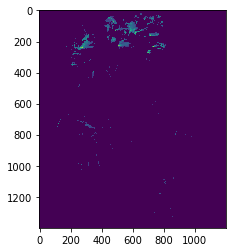

In [160]:
plt.imshow(vmi[0])

In [97]:
data['VMI'].shape

(1400, 1200)

In [ ]:
T = data['TEMP']

In [ ]:
plt.imshow(T[5, :, :] * (T[5, :, :] > -9999.0))

In [ ]:
with tiledb.DenseArray(radar_array, mode='r', ctx=TILEDB_CTX) as A:
    data = A[0:10,:,:]

In [ ]:
res

In [ ]:
args = {
    'after': '2019-06-15T11:00:00Z',
    'before':'2019-06-20T11:50:25Z',
    'bucket': 600,
    'op': 'sum'
}
code = '54d2c631-60ff-3f9a-879d-7b2a90b86184'
res = requests.get(f'{TDMQ_BASE_URL}/sensors/{code}/timeseries', params=args).json()

In [ ]:
res

In [ ]:
import abc

class TimeSeries(abc.ABC):

    def pre_fetch(self):
        base_url = self.sensor.client.base_url
        code = self.sensor.code
        args = {'after': self.after, 'before': self.before,
                'bucket': self.bucket, 'op': op}
        res = requests.get(f'{base_url}/sensors/{code}/timeseries', params=args).json()
        self.timebase = res['timebase']
        self.timedelta = np.array(res['timedelta'])
        return res['data']
    
    
    @abc.abstractmethod
    def fetch(self):
        pass
    
    @abc.abstractmethod
    def get_item(self, args):
        pass
    
    def __getitem__(self, indx):
        return self.get_item(np.index_exp[indx])

    def __init__(self, sensor, after, before, bucket, op):
        self.sensor = sensor
        self.after = after
        self.before = before
        self.bucket = bucket
        self.op = op
        self.fetch()


In [ ]:
class ScalarTimeSeries(TimeSeries):
    def fetch(self):
        data = self.pre_fetch()
        # FIXME multi channel sensors would be supported using something like
        # self.data = dict((fname, np.array(res['data'][fname] for fname in res['data'])
        self.data = np.array(data)
    def get_item(self, args):
        assert len(args) == 1
        return (self.timedelta[args], self.data[args])

In [ ]:
def fetch_data_block(block_of_refs, args):
    urls = set(r[0] for r in block_of_refs)
    # FIXME we support only the trivial case, for the time being
    assert len(urls) == 1
    indices = np.array([r[1] for r in block_of_refs], dtype=np.int32)
    assert np.all(indices[1:] - indices[:-1] == 1)   
    s = slice(indices.min(), indices.max() + 1)
    
    

class NonScalarTimeSeries(TimeSeries):
    def fetch(self):
        self.data = self.pre_fetch()
    def fetch_data_block(self, args):
        if self.bucket is None:
            block_of_refs = self.data[args[0]]
            block_of_refs = block_of_refs\
                            if isinstance(block_of_refs, list) else [block_of_refs]
            return fetch_data_block(block_of_refs, args[1:]))
        else:
          raise ValueError(f'bucket not supported')
    def get_item(self, args):
        assert len(args) > 0
        timedeltas = self.timedelta[args[0]]
        if isinstance(args[0], slice) and len(timedeltas) == 0:
            return (timedeltas, array([], dtype=int32))
        else:
            return (timedeltas, self.fetch_data_block(args))


In [ ]:


class ScalarTimeSeries(TimeSeries):
    def fetch(self):
        res = self.pre_fetch()
        self.timebase = res['timebase']
        self.timedelta = np.numpy(res['timedelta'])
        # FIXME multi channel sensors would be something like
        self.data = dict((fname, np.array))
        self.data = 
        

class SensorProxy(abc.ABC):
    def __init__(self, client, sensor_type, description):
        self.client = client
        self.code = description['code']
        self.sensor_type = sensort_type
        self.desc = description
    def geometry(self):
        return self.desc['geometry']
    @abc.abstractmethod
    def timeseries(self, after, before, bucket, op):
        
class ScalarSensorProxy:
    def __init__(self, client, sensor_type, sensor):
        self.client = client
        self.sensor_type = sensor_type
        self.sensor = sensor
    def geometry(self):
        return self.sensor['geometry']
    def timeseries(self, after, before, bucket, op):
        pass
    def 
        

class client:
    def __init__(self, tdmq_base_url):
        self.base_url = tdmq_base_url
        self.sensor_types = None
        self.update_sensor_types()
    def update_sensor_types(self):
        stypes = requests.get(f'{self.base_url}/sensor_types').json()
        self.sensor_types = dict((st['code'], st) for st in stypes)
    def make_sensor_proxy(self, sensors):
        
    def get_sensors(self, args):
        res = requests.get(f'{self.base_url}/sensors', params=args).json()
        return self.make_sensor_proxy(res)
        

In [ ]:
import pandas as pd

In [ ]:
class AA:
    def __getitem__(self, a):
        return np.index_exp[a]

In [ ]:
aa = AA(); print(aa[2, 3:4, 6])

In [ ]:
np.index_exp[2::2, 4:10:1]

In [ ]:
def foo(args):
    return np.index_exp[args]

In [ ]:
foo[1:2, 20:30, 123:444, 55:99]

In [ ]:
ts[i]
(t[i], v[i])
ts.shape
(120, 1024, 1024)
ts[i, 32:64, 32:64]

(t[120], data[120, 32:64. 32:64])
ts[1:10, 32:64, 32:64]
(t[1:10], data[1:10, 32:64, 32:64])

In [ ]:
a = np.array(range(10), dtype=np.int32)

In [ ]:
np.all(a[1:] - a[:-1] == 1)

In [ ]:
a[0:0]

In [ ]:
a = set([1,2])

In [ ]:
a.pop()

In [ ]:
len(a)